In [7]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
# import basic plot tools
from qiskit.visualization import plot_histogram

In [8]:

qreg = QuantumRegister(5)
ancillary = QuantumRegister(2)

qc = QuantumCircuit(qreg, ancillary)
qc.ccx(qreg[0],qreg[1],ancillary[0])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.cx(ancillary[0], ancillary[1])
qc.cx(ancillary[1], qreg[4])
qc.cx(ancillary[0], ancillary[1])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.ccx(qreg[0],qreg[1],ancillary[0])
qc.draw()


qreg = QuantumRegister(5)

ancillary = QuantumRegister(4)



#qc.barrier(qreg)
qc.draw()

q12_0: ──■─────────────────────────────■──
         │                             │  
q12_1: ──■─────────────────────────────■──
         │                             │  
q12_2: ──┼────■───────────────────■────┼──
         │    │                   │    │  
q12_3: ──┼────■───────────────────■────┼──
         │    │       ┌───┐       │    │  
q12_4: ──┼────┼───────┤ X ├───────┼────┼──
       ┌─┴─┐  │       └─┬─┘       │  ┌─┴─┐
q13_0: ┤ X ├──┼────■────┼────■────┼──┤ X ├
       └───┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐┌─┴─┐└───┘
q13_1: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├─────
            └───┘└───┘     └───┘└───┘

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
creg = ClassicalRegister(5)
for i in range(0,16): 
    print("****",'{0:04b}'.format(i),i)
    q = QuantumCircuit(qreg, ancillary, creg)
    s='{0:04b}'.format(i)
    for j in range(len(s)):
        if(s[j]=="1"):
            q.x(j)
    q.compose(qc, inplace = True)
    for j in range(5):
        q.measure(qreg[j],creg[j])
    q.draw()
    transpiled_q = transpile(q, aer_sim)
    qobj = assemble(transpiled_q)
    results = aer_sim.run(qobj,shots =1024).result()
    counts = results.get_counts()
    print(counts)  

**** 0000 0
{'00000': 1024}
**** 0001 1
{'01000': 1024}
**** 0010 2
{'00100': 1024}
**** 0011 3
{'11100': 1024}
**** 0100 4
{'00010': 1024}
**** 0101 5
{'01010': 1024}
**** 0110 6
{'00110': 1024}
**** 0111 7
{'11110': 1024}
**** 1000 8
{'00001': 1024}
**** 1001 9
{'01001': 1024}
**** 1010 10
{'00101': 1024}
**** 1011 11
{'11101': 1024}
**** 1100 12
{'10011': 1024}
**** 1101 13
{'11011': 1024}
**** 1110 14
{'10111': 1024}
**** 1111 15
{'01111': 1024}


In [11]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [32]:
creg = ClassicalRegister(4)
qcgrover = QuantumCircuit(qreg, ancillary, creg)

# Initialize qubits in state |s>
qcgrover.x(4)
qcgrover.h(range(5))

qcgrover.barrier() 

for j in range(1):
    qcgrover.compose(qc, inplace = True)
    qcgrover.append(diffuser(4),range(4))
    
qcgrover.barrier() 

qcgrover.h(4)
#qc.x(range(10))

# Measure the variable qubits
for i in range(4):
    qcgrover.measure(qreg[i], creg[i])

qcgrover.draw()

┌───┐      ░                                    ┌──────┐ ░      ┌─┐   »
q14_0: ┤ H ├──────░───■─────────────────────────────■──┤0     ├─░──────┤M├───»
       ├───┤      ░   │                             │  │      │ ░      └╥┘┌─┐»
q14_1: ┤ H ├──────░───■─────────────────────────────■──┤1     ├─░───────╫─┤M├»
       ├───┤      ░   │                             │  │  U_s │ ░       ║ └╥┘»
q14_2: ┤ H ├──────░───┼────■───────────────────■────┼──┤2     ├─░───────╫──╫─»
       ├───┤      ░   │    │                   │    │  │      │ ░       ║  ║ »
q14_3: ┤ H ├──────░───┼────■───────────────────■────┼──┤3     ├─░───────╫──╫─»
       ├───┤┌───┐ ░   │    │       ┌───┐       │    │  └──────┘ ░ ┌───┐ ║  ║ »
q14_4: ┤ X ├┤ H ├─░───┼────┼───────┤ X ├───────┼────┼───────────░─┤ H ├─╫──╫─»
       └───┘└───┘ ░ ┌─┴─┐  │       └─┬─┘       │  ┌─┴─┐         ░ └───┘ ║  ║ »
q15_0: ───────────░─┤ X ├──┼────■────┼────■────┼──┤ X ├─────────░───────╫──╫─»
                  ░ └───┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐┌─┴─┐└───┘         ░       ║  ║ »
q15_1: ───────────░──────┤ X ├┤ X ├──■──┤ X ├┤ X ├──────────────░───────╫──╫─»
                  ░      └───┘└───┘     └───┘└───┘              ░       ║  ║ »
q15_2: ───────────░─────────────────────────────────────────────░───────╫──╫─»
                  ░                                             ░       ║  ║ »
q15_3: ───────────░─────────────────────────────────────────────░───────╫──╫─»
                  ░                                             ░       ║  ║ »
c11: 4/═════════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
«             
«q14_0: ──────
«             
«q14_1: ──────
«       ┌─┐   
«q14_2: ┤M├───
«       └╥┘┌─┐
«q14_3: ─╫─┤M├
«        ║ └╥┘
«q14_4: ─╫──╫─
«        ║  ║ 
«q15_0: ─╫──╫─
«        ║  ║ 
«q15_1: ─╫──╫─
«        ║  ║ 
«q15_2: ─╫──╫─
«        ║  ║ 
«q15_3: ─╫──╫─
«        ║  ║ 
«c11: 4/═╩══╩═
«        2  3

{'1100': 121, '0011': 164, '0111': 135, '1101': 138, '1011': 146, '1001': 18, '0101': 15, '1110': 154, '0010': 16, '0100': 13, '1111': 16, '0001': 14, '1000': 21, '0000': 13, '1010': 27, '0110': 13}


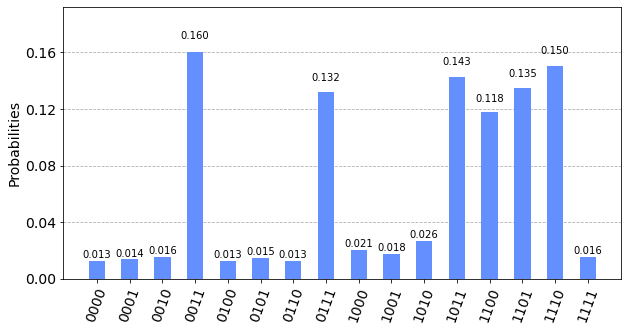

In [31]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qcgrover = transpile(qcgrover, aer_sim)
qobjgrover = assemble(transpiled_qcgrover)
resultsgrover = aer_sim.run(qobjgrover,shots =1024).result()
countsgrover = resultsgrover.get_counts()
print(countsgrover)
plot_histogram(countsgrover)
display(plot_histogram(countsgrover, figsize=(10, 5), color=None, number_to_keep=None, sort='asc', target_string=None, legend=None, bar_labels=True, title=None, ax=None, filename=None))

In [30]:
qc = QuantumCircuit(qreg, ancillary)
qc.barrier(qreg)
qc.ccx(qreg[0],qreg[1],ancillary[0])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.cx(ancillary[0], ancillary[2])
qc.cx(ancillary[1], ancillary[2])
qc.cx(ancillary[2], qreg[4])
qc.cx(ancillary[1], ancillary[2])
qc.cx(ancillary[0], ancillary[2])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.ccx(qreg[0],qreg[1],ancillary[0])

In [33]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
# import basic plot tools
from qiskit.visualization import plot_histogram

qreg = QuantumRegister(5)
ancillary = QuantumRegister(2)

qc = QuantumCircuit(qreg, ancillary)
qc.ccx(qreg[0],qreg[1],ancillary[0])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.cx(ancillary[0], ancillary[1])
qc.cx(ancillary[1], qreg[4])
qc.cx(ancillary[0], ancillary[1])
qc.ccx(qreg[2], qreg[3], ancillary[1])
qc.ccx(qreg[0],qreg[1],ancillary[0])

#qc.draw()

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

creg = ClassicalRegister(4)
qcgrover = QuantumCircuit(qreg, ancillary, creg)

# Initialize qubits in state |s>
qcgrover.x(4)
qcgrover.h(range(5))

qcgrover.barrier() 

for j in range(1):
    qcgrover.compose(qc, inplace = True)
    qcgrover.append(diffuser(4),range(4))
    
qcgrover.barrier() 

qcgrover.h(4)
#qc.x(range(10))

# Measure the variable qubits
for i in range(4):
    qcgrover.measure(qreg[i], creg[i])

qcgrover.draw()

┌───┐      ░                                    ┌──────┐ ░      ┌─┐   »
q666_0: ┤ H ├──────░───■─────────────────────────────■──┤0     ├─░──────┤M├───»
        ├───┤      ░   │                             │  │      │ ░      └╥┘┌─┐»
q666_1: ┤ H ├──────░───■─────────────────────────────■──┤1     ├─░───────╫─┤M├»
        ├───┤      ░   │                             │  │  U_s │ ░       ║ └╥┘»
q666_2: ┤ H ├──────░───┼────■───────────────────■────┼──┤2     ├─░───────╫──╫─»
        ├───┤      ░   │    │                   │    │  │      │ ░       ║  ║ »
q666_3: ┤ H ├──────░───┼────■───────────────────■────┼──┤3     ├─░───────╫──╫─»
        ├───┤┌───┐ ░   │    │       ┌───┐       │    │  └──────┘ ░ ┌───┐ ║  ║ »
q666_4: ┤ X ├┤ H ├─░───┼────┼───────┤ X ├───────┼────┼───────────░─┤ H ├─╫──╫─»
        └───┘└───┘ ░ ┌─┴─┐  │       └─┬─┘       │  ┌─┴─┐         ░ └───┘ ║  ║ »
q667_0: ───────────░─┤ X ├──┼────■────┼────■────┼──┤ X ├─────────░───────╫──╫─»
                   ░ └───┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐┌─┴─┐└───┘         ░       ║  ║ »
q667_1: ───────────░──────┤ X ├┤ X ├──■──┤ X ├┤ X ├──────────────░───────╫──╫─»
                   ░      └───┘└───┘     └───┘└───┘              ░       ║  ║ »
 c12: 4/═════════════════════════════════════════════════════════════════╩══╩═»
                                                                         0  1 »
«              
«q666_0: ──────
«              
«q666_1: ──────
«        ┌─┐   
«q666_2: ┤M├───
«        └╥┘┌─┐
«q666_3: ─╫─┤M├
«         ║ └╥┘
«q666_4: ─╫──╫─
«         ║  ║ 
«q667_0: ─╫──╫─
«         ║  ║ 
«q667_1: ─╫──╫─
«         ║  ║ 
« c12: 4/═╩══╩═
«         2  3

{'1011': 158, '0001': 16, '1010': 19, '1001': 17, '1110': 142, '0111': 139, '1100': 152, '0011': 143, '1101': 144, '0101': 16, '0000': 14, '0010': 18, '0110': 15, '1111': 14, '0100': 6, '1000': 11}


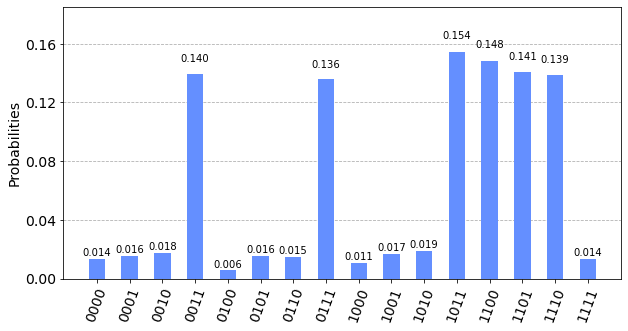

In [34]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qcgrover = transpile(qcgrover, aer_sim)
qobjgrover = assemble(transpiled_qcgrover)
resultsgrover = aer_sim.run(qobjgrover,shots =1024).result()
countsgrover = resultsgrover.get_counts()
print(countsgrover)
plot_histogram(countsgrover)
display(plot_histogram(countsgrover, figsize=(10, 5), color=None, number_to_keep=None, sort='asc', target_string=None, legend=None, bar_labels=True, title=None, ax=None, filename=None))